# Max_Daily_Energy_Predictions_Project
Max Daily Energy Prediction using Regression Analysis

Author - Udhai P Singh


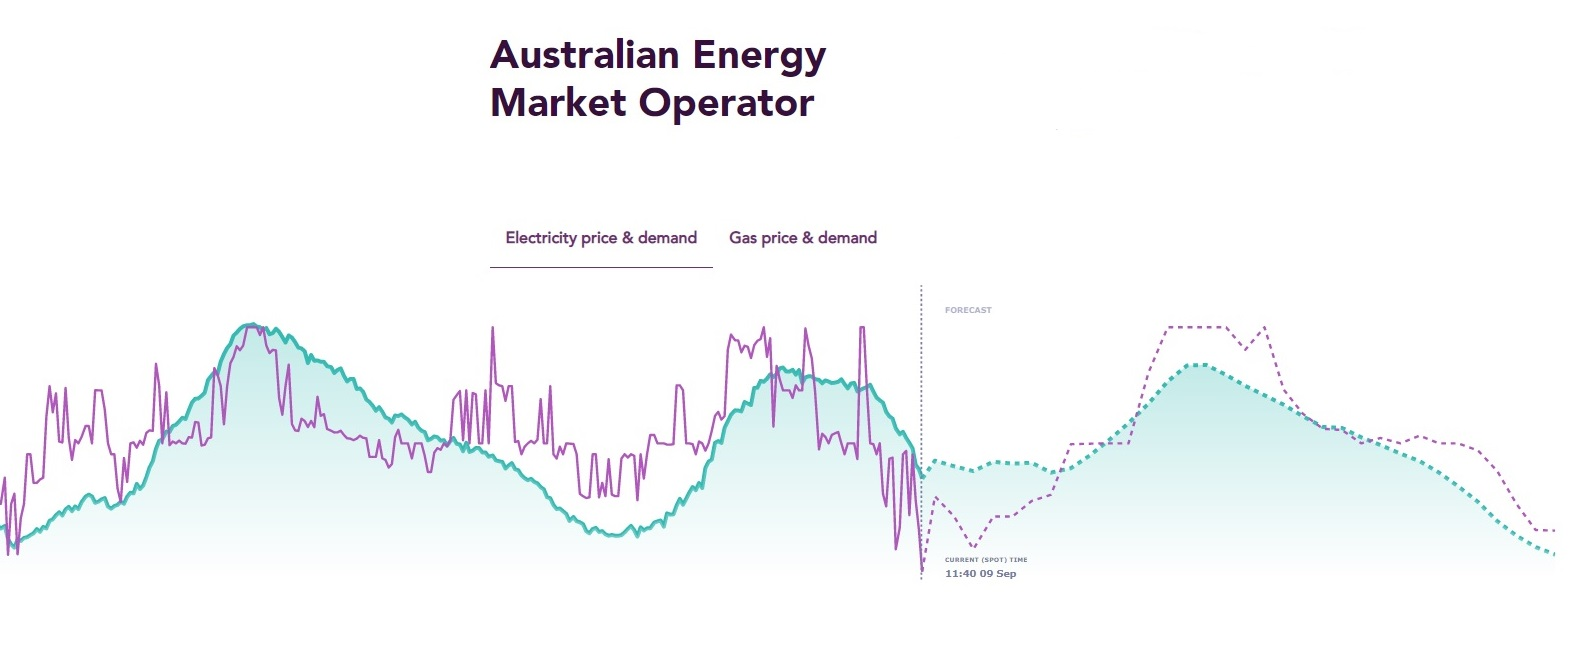


## Project Overview

This project analyzes the electricity consumption of Melbourne from 01.01.2021 to 31.08.2021. It is often observed that electricity consumption has strong relation with weather, especially temperature and time of the year/season. We will analyze the relationship of electricity consumption in Melbourne based on various weather features like temperature, wind, month and so on. The goal here is to predict maximum daily energy demand for Melbourne based on weather forecast. 

Our stakeholders, the electricity providers, can use this model to plan for the expected demand and hence make arrangements as participants of National Electricity Market(NEM) to lock in the expected demand at the right price.

For the purpose of our analysis, we will only consider the Randoms drivers related to weather-driven coincident customer behavior as well as weather-driven embedded generation output. Structural drivers like population, economic growth, technology adoption, etc have not been considered and outside the scope of this project. 


***
## Data:

The following two datasets are used:
1. price_demand_data.csv: This excel contains price and demand for each 30 minutes period from 01.01.2021 to 31.08.2021, for Victoria, Australia. RRP column has been removed from the data. For more details, please refer to the data source: https://aemo.com.au/energy-systems/electricity/national-electricity-market-nem/data-nem/aggregated-data

2. weather_data.csv: contains various weather features like temperature, wind pressure, wind direction and so forth, for each day from 01.01.2021 to 31.08.2021. Note, that these readings are on daily interval ie. one readign per day. 

***
## Busines Problem

The retail electricity provider participates in NEM in the spot market to procure electricity to sell it to consumers. NEM participants need to manage the financial risks associated with the significant spot price volatility that occurs during trading periods. Providers hedge their risk by locking in  a firm price for electricity that will be produced or consumed at a given time in the future. These arrangements are generally in the form of derivatives, and include swaps or hedges, options and futures contracts.

In order to enter various purchasing arrangements at the right price, the demand forecast becomes critical especially the maximum demands for which the retails need to be prepared, otherwise purchasing units from the spot market at last minute to meet unexpected peak demand is exorbitantly expensive as compared to long term purchasing contracts.  

To solve this problem for our stakeholders, we are trying to predict the daily maximum electricity demand based on weather forecast for Melbourne. 

In [1]:
# importing standard packages as per our requirements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from IPython import display
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

In [2]:
weather_df = pd.read_csv(
    "data/weather_data.csv", parse_dates=["Date"], sep=",", dayfirst=True
)

In [3]:
weather_df.head(5)

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,2021-01-01,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
1,2021-01-02,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2,2021-01-03,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
3,2021-01-04,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
4,2021-01-05,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3


In [4]:
weather_df.describe()

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am Temperature (°C),9am relative humidity (%),9am cloud amount (oktas),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm MSL pressure (hPa)
count,242.000000,242.000000,241.000000,243.000000,243.000000,240.000000,242.000000,242.000000,243.000000,241.000000,243.000000,243.000000,242.000000,242.000000
mean,11.050826,19.445868,1.576763,3.902469,5.349383,34.412500,13.720661,74.454545,5.164609,1017.740664,18.040329,56.930041,5.301653,1015.824793
std,3.870242,5.354085,4.498754,2.702141,3.604902,10.909319,4.306618,14.177593,2.562778,7.683402,4.963547,14.017376,2.392051,7.435859
min,1.700000,10.600000,0.000000,0.000000,0.000000,15.000000,3.000000,25.000000,0.000000,989.700000,8.600000,21.000000,0.000000,989.000000
25%,8.100000,15.500000,0.000000,1.900000,2.150000,28.000000,10.925000,65.000000,3.000000,1012.800000,14.400000,48.000000,3.000000,1011.000000
50%,10.900000,18.300000,0.000000,3.200000,4.900000,33.000000,13.400000,75.000000,7.000000,1018.100000,17.100000,56.000000,7.000000,1015.750000
75%,13.800000,21.800000,0.600000,5.600000,8.350000,41.000000,16.400000,84.000000,7.000000,1023.700000,20.150000,66.000000,7.000000,1021.600000
max,22.200000,39.200000,43.200000,13.800000,13.100000,67.000000,30.900000,100.000000,8.000000,1034.200000,35.200000,98.000000,8.000000,1032.400000


In [5]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               243 non-null    datetime64[ns]
 1   Minimum temperature (°C)           242 non-null    float64       
 2   Maximum temperature (°C)           242 non-null    float64       
 3   Rainfall (mm)                      241 non-null    float64       
 4   Evaporation (mm)                   243 non-null    float64       
 5   Sunshine (hours)                   243 non-null    float64       
 6   Direction of maximum wind gust     240 non-null    object        
 7   Speed of maximum wind gust (km/h)  240 non-null    float64       
 8   Time of maximum wind gust          240 non-null    object        
 9   9am Temperature (°C)               242 non-null    float64       
 10  9am relative humidity (%)          242

In [6]:
price_demand_df = pd.read_csv(
    "data/price_demand_data.csv", parse_dates=["SETTLEMENTDATE"], sep=",", dayfirst=True
)

In [7]:
price_demand_df.tail(5)

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICECATEGORY
11659,VIC1,2021-08-31 22:00:00,4861.91,MEDIUM
11660,VIC1,2021-08-31 22:30:00,4748.74,MEDIUM
11661,VIC1,2021-08-31 23:00:00,4620.09,MEDIUM
11662,VIC1,2021-08-31 23:30:00,4834.00,MEDIUM
11663,VIC1,2021-09-01 00:00:00,4811.27,MEDIUM


In [8]:
price_demand_df.describe()

,TOTALDEMAND
count,11664.000000
mean,4925.798454
std,876.407490
min,2708.530000
25%,4255.500000
50%,4803.755000
75%,5477.337500
max,8196.830000


In [9]:
price_demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11664 entries, 0 to 11663
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   REGION          11664 non-null  object        
 1   SETTLEMENTDATE  11664 non-null  datetime64[ns]
 2   TOTALDEMAND     11664 non-null  float64       
 3   PRICECATEGORY   11664 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 364.6+ KB


In [10]:
price_demand_df["Date"] = price_demand_df.SETTLEMENTDATE
price_demand_df.Date = pd.to_datetime(price_demand_df["Date"]).dt.date
price_demand_df.TOTALDEMAND = price_demand_df.TOTALDEMAND.astype(int)
gp1 = price_demand_df.groupby("Date").TOTALDEMAND.max().reset_index()
gp2 = price_demand_df.groupby("Date").PRICECATEGORY.max().reset_index()

## Hourly Trend

#### We are exploring if there is a hourly trend which might be useful for predicting the daily maximum demand. An important consideration while exploring this trend is that, although we are choosing the maximum value corresponding to an particular 30 min period in a day, but this hourly trend need not be confined to that specific 30 min period. This could actually be any period throughout the day. 

#### The idea behind this is that the hourly trend can be both the leading or a lagging indicator for the peak hour. If we find a trend than we can construct features to capture that impact on our max daily demand. 

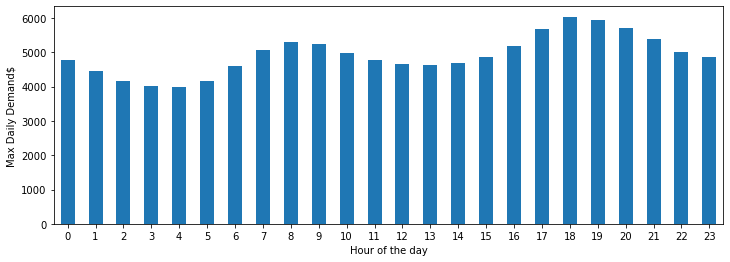

In [11]:
fig, axs = plt.subplots(figsize=(12, 4))

price_demand_df.groupby(price_demand_df["SETTLEMENTDATE"].dt.hour)[
    "TOTALDEMAND"
].mean().plot(kind="bar", rot=0, ax=axs)

plt.xlabel("Hour of the day")
# custom x label using Matplotlib

plt.ylabel("Max Daily Demand$");

#### As expected, the hour of the day matters even on a eight month span. Electricity consumption is maximum at 6pm in the evening. Whereas the mean hourly electricity consumption dips to a minimum at 3 am. So this should inform at what time most generators come on and off the grid. This should inform the hourly forecast of the retail distributors. 

In [12]:
gp1.drop([243], inplace=True)
gp2.drop([243], inplace=True)
gp3 = gp1.join(gp2.set_index("Date"), on="Date")

In [13]:
weather_df["9am wind direction"] = weather_df["9am wind direction"].replace(
    " ", "missing"
)
weather_df["3pm wind direction"] = weather_df["3pm wind direction"].replace(
    " ", "missing"
)

weather_df["9am wind speed (km/h)"] = (
    weather_df["9am wind speed (km/h)"].replace("Calm", np.nan).astype(float)
)
weather_df["3pm wind speed (km/h)"] = (
    weather_df["3pm wind speed (km/h)"].replace("Calm", np.nan).astype(float)
)

In [14]:
imputer = SimpleImputer(strategy="constant", fill_value="missing")

directions_df = pd.DataFrame(
    imputer.fit_transform(
        weather_df[["Direction of maximum wind gust ", "9am wind direction"]]
    )
)

weather_df[["Direction of maximum wind gust ", "9am wind direction"]] = directions_df[
    [0, 1]
]

#### These are readings of the 16 point compass. Hence, there is an order and relation of these categoreies with each other. We will proceed ahead to encode the 16 points as ordinal variable and thus aim to get the relationship of particular direction and demand. 



In [15]:
directions = [
    "Direction of maximum wind gust ",
    "9am wind direction",
    "3pm wind direction",
]

sixteen_pts = [
    "N",
    "NNE",
    "NE",
    "ENE",
    "E",
    "ESE",
    "SE",
    "SSE",
    "S",
    "SSW",
    "SW",
    "WSW",
    "W",
    "WNW",
    "NW",
    "NNW",
    "missing",
]

from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(categories=[sixteen_pts, sixteen_pts, sixteen_pts])

weather_df[
    ["Direction of maximum wind gust ", "9am wind direction", "3pm wind direction"]
] = pd.DataFrame(
    oe.fit_transform(
        weather_df[
            [
                "Direction of maximum wind gust ",
                "9am wind direction",
                "3pm wind direction",
            ]
        ]
    )
)

weather_df.head(5)

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,2021-01-01,15.6,29.9,0.0,2.8,9.3,1.0,31.0,13:14,19.2,...,6,0.0,2.0,1018.8,28.1,43,5.0,4.0,13.0,1015.3
1,2021-01-02,18.4,29.0,0.0,9.4,1.3,15.0,30.0,8:22,23.3,...,7,15.0,17.0,1013.3,28.7,38,7.0,10.0,4.0,1008.5
2,2021-01-03,17.0,26.2,12.6,4.8,7.1,11.0,33.0,17:55,18.3,...,8,11.0,4.0,1007.7,23.5,59,4.0,9.0,2.0,1005.2
3,2021-01-04,16.0,18.6,2.6,3.8,0.0,7.0,41.0,16:03,16.2,...,8,7.0,11.0,1010.0,18.2,82,8.0,9.0,17.0,1011.0
4,2021-01-05,15.9,19.1,11.2,1.0,0.0,7.0,35.0,11:02,17.2,...,8,7.0,13.0,1012.5,18.2,82,8.0,7.0,19.0,1013.3


In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

missing_vals_cols = ["Minimum temperature (°C)",
        "Maximum temperature (°C)",
        "Rainfall (mm)",
        "Speed of maximum wind gust (km/h)",
        "9am Temperature (°C)",
        "9am relative humidity (%)",
        "9am wind speed (km/h)",
        "9am MSL pressure (hPa)",
        "3pm cloud amount (oktas)",
        "3pm wind speed (km/h)",
        "3pm MSL pressure (hPa)",]

impute_it = IterativeImputer()
weather_df[missing_vals_cols] = pd.DataFrame(impute_it.fit_transform(weather_df[missing_vals_cols]))

In [17]:
## Dropping Time of maximum wind gust, as the day to day variability is too high and seems random.
## Infact, in order to capture any impact of time, we will create separate month, weekend, weekday, columns
## Subsequency after merging the two datasets, we should check the correlations of these new columns with our
## dependant variables

weather_df.drop(columns=["Time of maximum wind gust"], axis=1, inplace=True)
weather_df["month"] = weather_df.Date.dt.month
weather_df["day_of_week"] = weather_df.Date.dt.day_of_week

## Merging both the datasets

In [18]:
final_df = pd.concat([weather_df, gp3.iloc[:, 1:3]], axis=1)
final_df.head(5)

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),9am Temperature (°C),9am relative humidity (%),...,3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),month,day_of_week,TOTALDEMAND,PRICECATEGORY
0,2021-01-01,15.6,29.9,0.0,2.8,9.3,1.0,31.0,19.2,77.0,...,28.1,43,5.0,4.0,13.0,1015.3,1,4,5019,LOW
1,2021-01-02,18.4,29.0,0.0,9.4,1.3,15.0,30.0,23.3,52.0,...,28.7,38,7.0,10.0,4.0,1008.5,1,5,4964,LOW
2,2021-01-03,17.0,26.2,12.6,4.8,7.1,11.0,33.0,18.3,100.0,...,23.5,59,4.0,9.0,2.0,1005.2,1,6,4503,LOW
3,2021-01-04,16.0,18.6,2.6,3.8,0.0,7.0,41.0,16.2,98.0,...,18.2,82,8.0,9.0,17.0,1011.0,1,0,4764,LOW
4,2021-01-05,15.9,19.1,11.2,1.0,0.0,7.0,35.0,17.2,96.0,...,18.2,82,8.0,7.0,19.0,1013.3,1,1,4800,LOW


In [19]:
X = final_df.iloc[:, 1:22]
y1 = final_df.iloc[:, 22:23]
y2 = final_df.iloc[:, 23:24]

In [20]:
corr = final_df.corr()
corr.sort_values(["TOTALDEMAND"], ascending=False, inplace=True)
print(
    "Correlation with TOTALDEMAND showing the most important features in decreasing order:"
)
print(corr.TOTALDEMAND)

Correlation with TOTALDEMAND showing the most important features in decreasing order:
TOTALDEMAND                          1.000000
month                                0.574329
9am wind speed (km/h)                0.127071
9am relative humidity (%)            0.104367
3pm cloud amount (oktas)             0.068739
Speed of maximum wind gust (km/h)    0.068069
3pm relative humidity (%)            0.064331
9am MSL pressure (hPa)               0.055608
3pm MSL pressure (hPa)               0.000427
3pm wind speed (km/h)               -0.035397
Rainfall (mm)                       -0.073171
Direction of maximum wind gust      -0.078329
Sunshine (hours)                    -0.139570
3pm wind direction                  -0.165738
9am cloud amount (oktas)            -0.167404
day_of_week                         -0.240428
Evaporation (mm)                    -0.264013
Maximum temperature (°C)            -0.290422
9am wind direction                  -0.298344
3pm Temperature (°C)                -0.3

### Groupby Exploration

In [21]:
data = final_df.copy()
monthly_df = (
    data.groupby(["month", "day_of_week"])
    .TOTALDEMAND.agg(["max", "min", "count", "median", "mean"])
    .reset_index()
)
monthly_df.head(5)

,month,day_of_week,max,min,count,median,mean
0,1,0,8196,4764,4,6538.5,6509.25
1,1,1,5349,4800,4,4925.5,5000.00
2,1,2,6522,4691,4,5256.0,5431.25
3,1,3,7046,4994,4,5327.5,5673.75
4,1,4,5954,4742,5,5365.0,5363.40


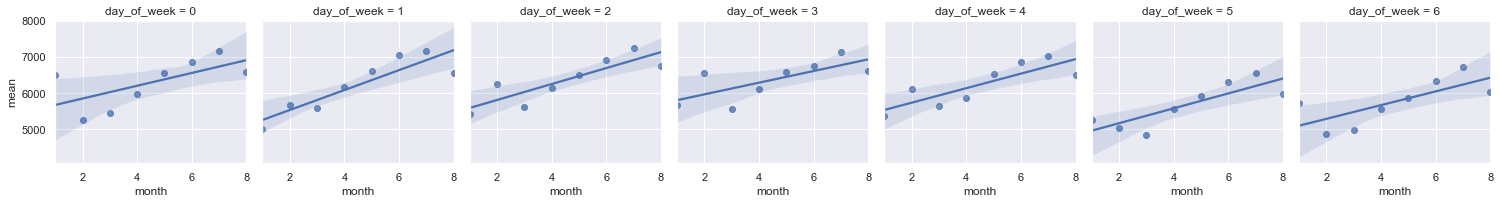

In [22]:
sns.set(rc={"figure.figsize": (18, 18)})
g = sns.FacetGrid(monthly_df, col="day_of_week")
g.map(sns.regplot, "month", "mean")

### The above facetgrid shows that the day of the week mays have some relationship with electricity consumption. It also shows a strong correlation between month and the price demand

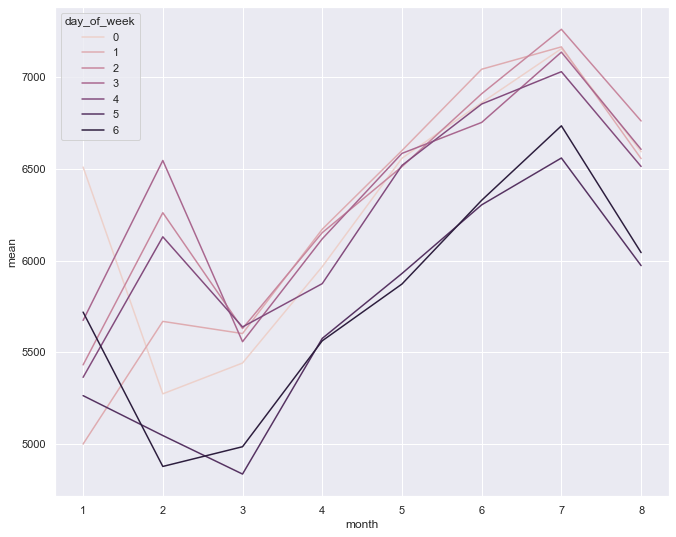

In [23]:
sns.set(rc={"figure.figsize": (11, 9)})
sns.lineplot(data=monthly_df, x="month", y="mean", hue="day_of_week", ci=None);

#### Lineplot demonstrates weekdays consume more Max energy than weekends for all months except January. This is due to abnormally huge demand on 11.01.2021 and 25.01.2021.  While the spike on 25.01.21 is explainable as it is part of the long weekend ago and maybe associate with Australia day celebrations. On the other hand, the spike on 11.04.22 seems like an abberation. Hence, our stakeholders needs to be prepared for these anamolies. 

#### Another anamoly in data is that weekend mean-max consumption dips in February whereas for weekdays it dips in March

#### The second change of trend for both weekend(0,6) and weekdays(0-4) is simultaneously in August where it breaks the increasing trend. 

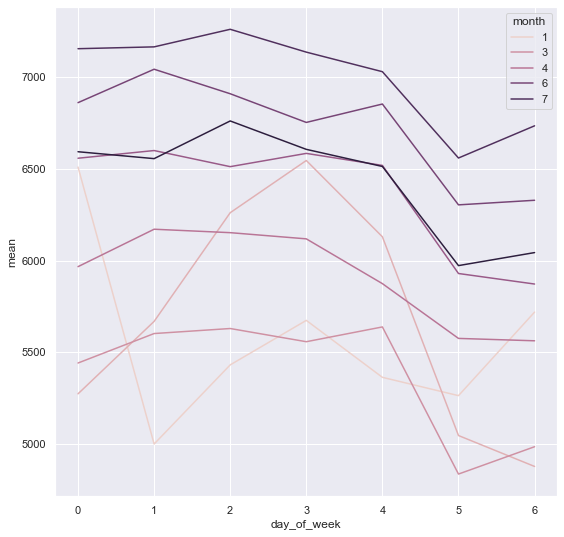

In [24]:
sns.set(rc={"figure.figsize": (9, 9)})
sns.lineplot(data=monthly_df, x="day_of_week", y="mean", hue="month", ci=None);

#### As expected the day of the week seems to have a strong relationship with the electricity demand. The demand is clearly higher on weekdays then on weekends, on general. Specifically the demand usually peaks on Mondays and Tuesdays and move down from there on - for all months - except January and February. 


#### For our stakeholders - July seems to be a critical period at the max consumption for both weekdays and weekends peaks together, hence the max capacity and the base load for July will increase substantially as compared to other months

### As we notice here that there are quite a few trends and  anamolies in our data. Furthermore we have used ordinal encoding for three directions related features. To add to this, we only have 243 rows of data, which is exceptionally small dataframe and hence the standard train test split can yeild some very usual and unreliable results with high variance. Hence to manange this, we are going to use stratified K -fold for our regression analysis. 

C:\Users\udhai\anaconda3\envs\learn-env\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\udhai\anaconda3\envs\learn-env\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


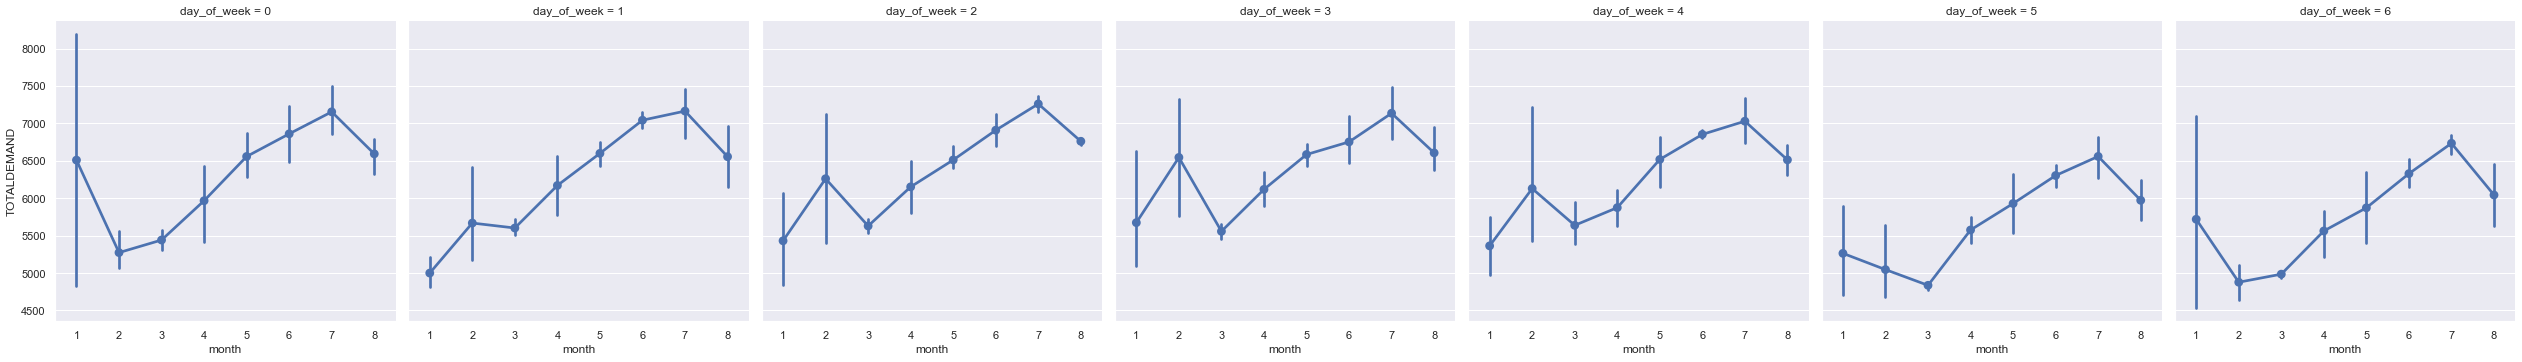

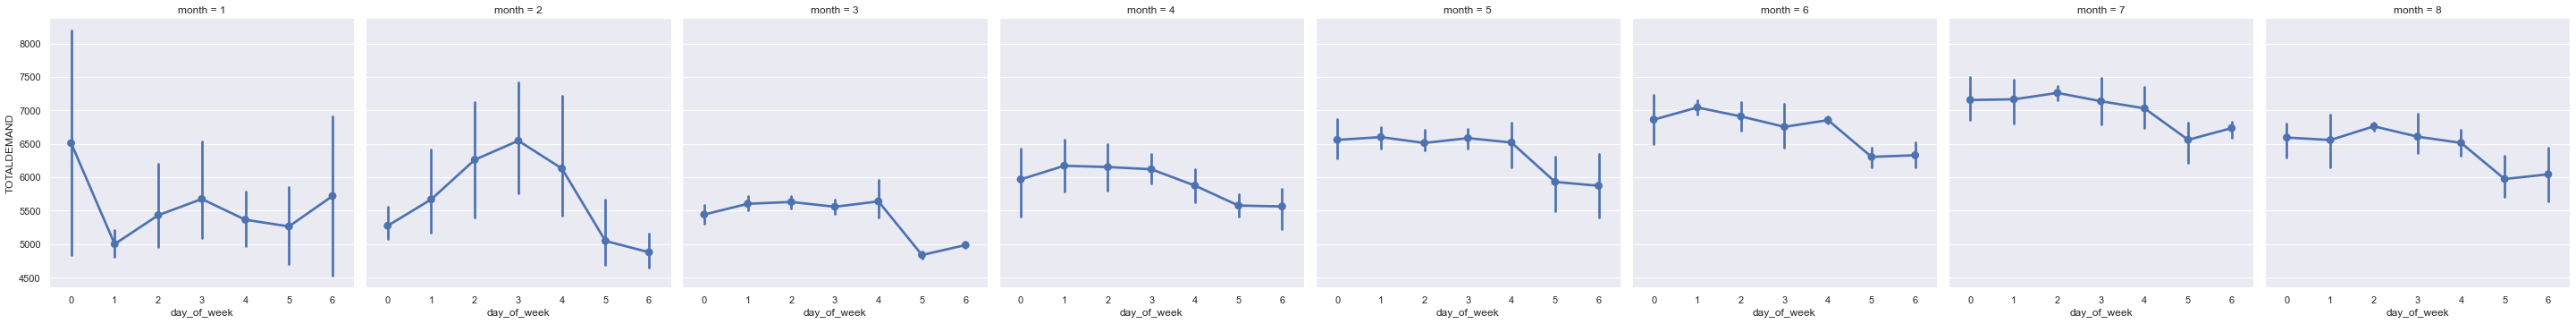

In [25]:
data = final_df.copy()
sns.set(rc={"figure.figsize": (30, 30)})
sns.factorplot(data=data, x="month", y="TOTALDEMAND", col="day_of_week")
sns.factorplot(data=data, x="day_of_week", y="TOTALDEMAND", col="month");

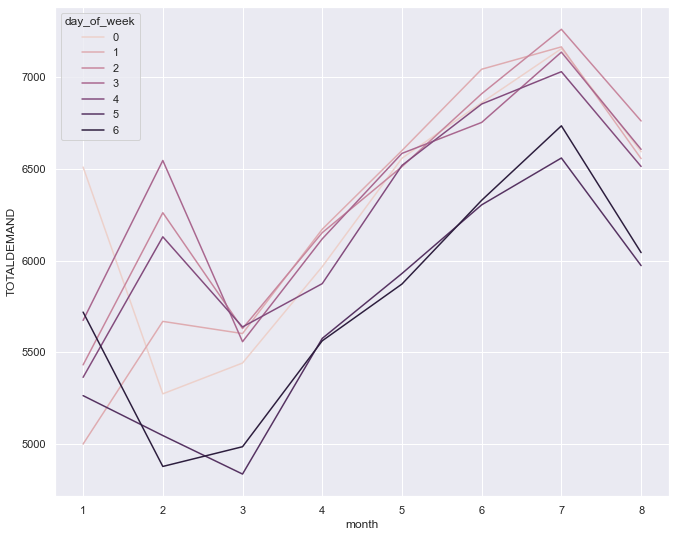

In [26]:
sns.set(rc={"figure.figsize": (11, 9)})
sns.lineplot(data=data, x="month", y="TOTALDEMAND", hue="day_of_week", ci=None);

<AxesSubplot:xlabel='day_of_week', ylabel='TOTALDEMAND'>

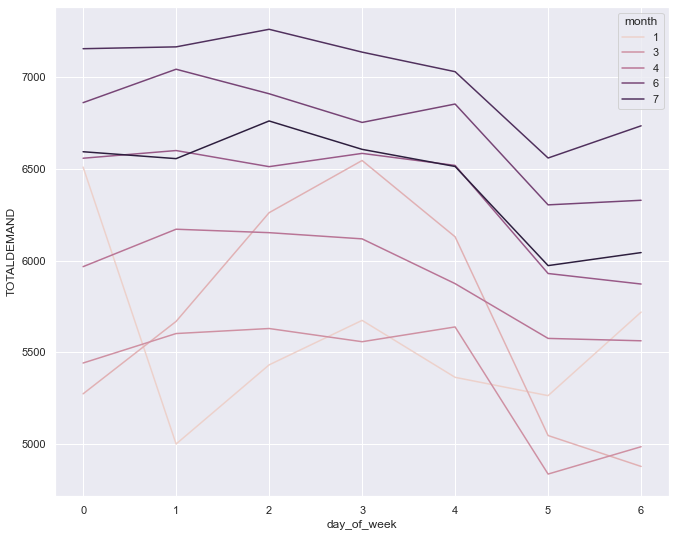

In [27]:
sns.lineplot(data=data, x="day_of_week", y="TOTALDEMAND", hue="month", ci=None)

***
***
## Base Model - Linear Regression to predict Max Daily Energy 

In [28]:
X = final_df[["month", "Maximum temperature (°C)", "Minimum temperature (°C)"]]
y = y1  # y1 represents the column with total demand

# Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=0.25, random_state=42
)
y_train = y_train.to_numpy()

# Generate the regression model (import .linear_model to use .LinearRegression() func)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_train_preds = linreg.predict(X_train)
y_test_preds = linreg.predict(X_test)

y_train_preds = y_train_preds.ravel()
y_test_preds = y_test_preds.ravel()

y_train = y_train.ravel()
y_test = y_test.to_numpy().ravel()

In [29]:
r2_train = r2_score(y_train, y_train_preds)
r2_test = r2_score(y_test, y_test_preds)

mse_train = mean_squared_error(y_train, y_train_preds)
mse_test = mean_squared_error(y_test, y_test_preds)

print(f"R2 train: {r2_train} R2 test: {r2_test}")
print(f"MSE train: {mse_train: .3e} MSE test: {mse_test: .3e}")

R2 train: 0.39422004663916377 R2 test: 0.3099374249296186
MSE train:  3.922e+05 MSE test:  4.892e+05


In [30]:
# We are defining a function to calcuate adjusted r_2 values as it is not available under sklearn.metrics


def adj_r2_score(r2, n_samples, n_regressors):
    factor = (n_samples - 1) / (n_samples - n_regressors - 1)
    return 1 - ((1 - r2) * factor)

In [31]:
adj_r2_train = adj_r2_score(r2_train, len(X_train), len(X_train.columns))
adj_r2_test = adj_r2_score(r2_test, len(X_test), len(X_test.columns))
print(f"Adj. R2 train: {adj_r2_train} Adj. R2 test: {adj_r2_test}")

Adj. R2 train: 0.38401027214431827 Adj. R2 test: 0.2736183420311775


Text(0, 0.5, 'Actual Max Demand')

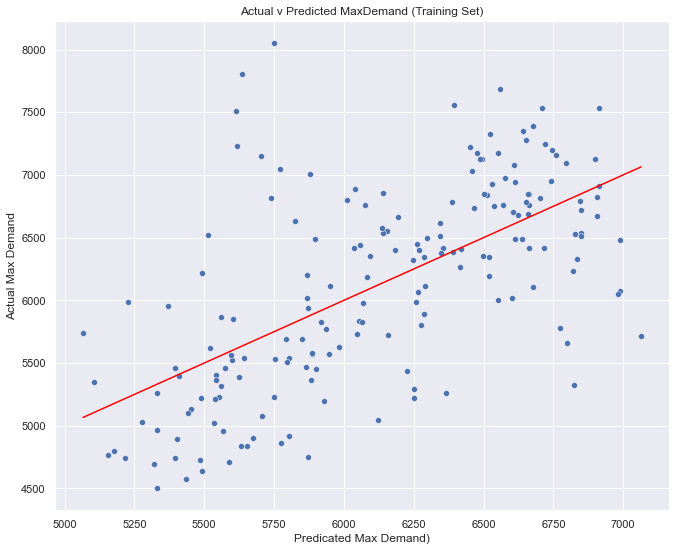

In [32]:
sns.scatterplot(x=y_train_preds, y=y_train)
sns.lineplot(x=y_train_preds, y=y_train_preds, color="red")
plt.title("Actual v Predicted MaxDemand (Training Set)")
plt.xlabel("Predicated Max Demand)")
plt.ylabel("Actual Max Demand")


#### Here, we might want to normalize the dependant variable and then try fitting out our basemodel again

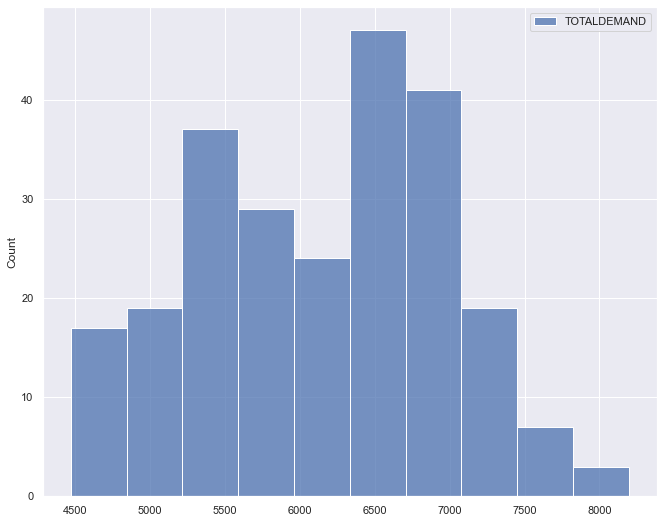

In [33]:
y = np.log1p(y1)
y = ((y - y.mean()) / y.std()).astype(int)
sns.histplot(y1);

### As compared to our original unscaled y values, our adj R2 test has increased from 0.27 to 0.32 and at the same time the MSE has decreased from 4.892e+05 to 0.0124. An extreme decrease.

### Actually, this decrease in metrics is too high, although it is always possible. But it is good to do a stratified cross validation here, so as to ensure the quality of our results and confirms the extreme reduction in MSE score is not random or an aberration.

***
### Stratified K Fold

In [34]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_train_preds = linreg.predict(X_train)
    y_test_preds = linreg.predict(X_test)

    model_score_test = model.score(X_test, y_test)
    model_score_train = model.score(X_train, y_train)
    
    r2_train = r2_score(y_train, y_train_preds)
    r2_test = r2_score(y_test, y_test_preds)
    
    mean_sqrd_error_train = mean_squared_error(y_train, y_train_preds)
    mean_sqrd_error_test = mean_squared_error(y_test, y_test_preds)

    return [model_score_test, model_score_train, r2_train, r2_test, mean_sqrd_error_train, mean_sqrd_error_test]

In [35]:
def Average(lst):
    return sum(lst) / len(lst)


# this will help us to calculate 1 mean for every 5 values for each metric

scores = []
model_test_scores = []
model_train_scores = []
r2_train_scores = []
r2_test_scores = []
mse_train_scores = []
mse_test_scores = []

skf = StratifiedKFold(n_splits=3, random_state=None)
skf.get_n_splits(X, y)

# We will split n_splits=3, as one of the classes in y has only 3 values.

# X is the feature set and y is the target

X = final_df[["month", "Maximum temperature (°C)", "Minimum temperature (°C)"]]
y = y

linreg = LinearRegression()

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    score = get_score(linreg, X_train, X_test, y_train, y_test)
    scores.append(score)
    model_test_scores.append(score[0])
    model_train_scores.append(score[1])
    r2_train_scores.append(score[2])
    r2_test_scores.append(score[3])
    mse_train_scores.append(score[4])
    mse_test_scores.append(score[5])
    # the returned object from get_score function is a list of 5 elements


print(f"model test scores are {model_test_scores} and the average model test score is {round(Average(model_test_scores),2)}"
)

print(
    f"5 model train scores are {model_train_scores} and the average model train score is {round(Average(model_train_scores),2)}"
)
print(
    f"5 r2 train scores are {r2_train_scores} and the average r2 train score is {round(Average(r2_train_scores),2)}"
)
print(
    f"5 r2 test scores are {r2_test_scores} and the average r2 test score is {round(Average(r2_test_scores),2)}"
)
print(
    f"5 mean_sqrd_error_train scores are {mse_train_scores} and average mse train score is {round(Average(mse_train_scores),2)}"
)
print(
    f"5 mean_sqrd_error_tests are {mse_test_scores} and the average mse test score is {round(Average(mse_test_scores),2)}"
)

model test scores are [-0.5416005103564885, 0.34254803878548457, -1.0048453528512673] and the average model test score is -0.4
5 model train scores are [0.3239719204874444, 0.142796541505388, 0.44091962551640407] and the average model train score is 0.3
5 r2 train scores are [0.3239719204874444, 0.142796541505388, 0.44091962551640407] and the average r2 train score is 0.3
5 r2 test scores are [-0.5416005103564885, 0.34254803878548457, -1.0048453528512673] and the average r2 test score is -0.4
5 mean_sqrd_error_train scores are [0.2988083265640011, 0.3635046978199413, 0.2370829708744071] and average mse train score is 0.3
5 mean_sqrd_error_tests are [0.625944788841592, 0.2905975746871049, 0.8861532576236358] and the average mse test score is 0.6


In [36]:
eval_list = list()
avg_score = dict()
avg_score["dataset"] = "baseline with stratified KFold"

avg_score["avg_model_test_score"] = round(Average(model_test_scores),2)
avg_score["avg_model_train_score"] = round(Average(model_train_scores),2)
avg_score["avg_r2_train"] = round(Average(r2_train_scores),2)
avg_score["avg_r2_test"] = round(Average(r2_test_scores),2)
avg_score["avg_mse_train"] = round(Average(mse_train_scores),2)
avg_score["avg_mse_test"] = round(Average(mse_test_scores),2)

avg_score["n_features"] = len(X.columns)

eval_list.append(avg_score)
pd.DataFrame(eval_list)

,dataset,avg_model_test_score,avg_model_train_score,avg_r2_train,avg_r2_test,avg_mse_train,avg_mse_test,n_features
0,baseline with stratified KFold,-0.4,0.3,0.3,-0.4,0.3,0.6,3


***
## Iteration : with all feats_pre transformation and scaling

In [37]:
X = final_df.drop(["Date", "TOTALDEMAND", "PRICECATEGORY"], axis=1)
y = y


scores = []
model_test_scores = []
model_train_scores = []
r2_train_scores = []
r2_test_scores = []
mse_train_scores = []
mse_test_scores = []
skf = StratifiedKFold(n_splits=3, random_state=None)
skf.get_n_splits(X, y)

linreg = LinearRegression()

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    score = get_score(linreg, X_train, X_test, y_train, y_test)
    scores.append(score)
    model_test_scores.append(score[0])
    model_train_scores.append(score[1])
    r2_train_scores.append(score[2])
    r2_test_scores.append(score[3])
    mse_train_scores.append(score[4])
    mse_test_scores.append(score[5])
    # the returned object from get_score function is a list of 5 elements


print(f"model test scores are {model_test_scores} and the average model test score is {round(Average(model_test_scores),2)}"
)

print(
    f"5 model train scores are {model_train_scores} and the average model train score is {round(Average(model_train_scores),2)}"
)
print(
    f"5 r2 train scores are {r2_train_scores} and the average r2 train score is {round(Average(r2_train_scores),2)}"
)
print(
    f"5 r2 test scores are {r2_test_scores} and the average r2 test score is {round(Average(r2_test_scores),2)}"
)
print(
    f"5 mean_sqrd_error_train scores are {mse_train_scores} and average mse train score is {round(Average(mse_train_scores),2)}"
)
print(
    f"5 mean_sqrd_error_tests are {mse_test_scores} and the average mse test score is {round(Average(mse_test_scores),2)}"
)

model test scores are [-1.2553072661250737, 0.277478955947004, -1.0325093958248153] and the average model test score is -0.67
5 model train scores are [0.5812364267553132, 0.3969987803399596, 0.5345347508582563] and the average model train score is 0.5
5 r2 train scores are [0.5812364267553132, 0.3969987803399596, 0.5345347508582563] and the average r2 train score is 0.5
5 r2 test scores are [-1.2553072661250737, 0.277478955947004, -1.0325093958248153] and the average r2 test score is -0.67
5 mean_sqrd_error_train scores are [0.18509592476902784, 0.2557079932021259, 0.19738465011806378] and average mse train score is 0.21
5 mean_sqrd_error_tests are [0.9157351862455717, 0.3193584861688292, 0.898380924842549] and the average mse test score is 0.71


In [38]:
avg_score = dict()
avg_score["dataset"] = "all feats_pre transformation and scaling"

avg_score["avg_model_test_score"] = round(Average(model_test_scores),2)
avg_score["avg_model_train_score"] = round(Average(model_train_scores),2)
avg_score["avg_r2_train"] = round(Average(r2_train_scores),2)
avg_score["avg_r2_test"] = round(Average(r2_test_scores),2)
avg_score["avg_mse_train"] = round(Average(mse_train_scores),2)
avg_score["avg_mse_test"] = round(Average(mse_test_scores),2)

avg_score["n_features"] = len(X.columns)

eval_list.append(avg_score)
pd.DataFrame(eval_list)

,dataset,avg_model_test_score,avg_model_train_score,avg_r2_train,avg_r2_test,avg_mse_train,avg_mse_test,n_features
0,baseline with stratified KFold,-0.40,0.3,0.3,-0.40,0.30,0.60,3
1,all feats_pre transformation and scaling,-0.67,0.5,0.5,-0.67,0.21,0.71,21


### If you notice the results above, we have partly acheived our objective to make the test samples more representative of all the hidden trends and class types in our data. 
### This was acheived by increasing the number of features from 3 to 21. 

In [39]:
continuous_feats = [
    "Minimum temperature (°C)",
    "Maximum temperature (°C)",
    "Rainfall (mm)",
    "Evaporation (mm)",
    "Sunshine (hours)",
    "Speed of maximum wind gust (km/h)",
    "9am Temperature (°C)",
    "9am relative humidity (%)",
    "9am cloud amount (oktas)",
    "9am wind speed (km/h)",
    "9am MSL pressure (hPa)",
    "3pm Temperature (°C)",
    "3pm relative humidity (%)",
    "3pm cloud amount (oktas)",
    "3pm wind speed (km/h)",
    "3pm MSL pressure (hPa)",
]

ordinal_dir = [
    "Direction of maximum wind gust ",
    "9am wind direction",
    "3pm wind direction",
]
time_feats = ["Date", "month", "day_of_week"]

In [40]:
continuous_df = final_df[continuous_feats]
# continuous_df.hist(figsize=[20,20], bins='auto');

In [41]:
continuous_df.skew(axis=0)

Minimum temperature (°C)             0.091033
Maximum temperature (°C)             1.107193
Rainfall (mm)                        5.447560
Evaporation (mm)                     1.062092
Sunshine (hours)                     0.245256
Speed of maximum wind gust (km/h)    0.560534
9am Temperature (°C)                 0.610747
9am relative humidity (%)           -0.279854
9am cloud amount (oktas)            -0.802511
9am wind speed (km/h)                0.922306
9am MSL pressure (hPa)              -0.548846
3pm Temperature (°C)                 0.966494
3pm relative humidity (%)            0.229416
3pm cloud amount (oktas)            -0.893073
3pm wind speed (km/h)                0.668156
3pm MSL pressure (hPa)              -0.474595
dtype: float64

In [42]:
skew_df = pd.DataFrame()
skew_df["original_skewness"] = continuous_df.skew(axis=0)
skew_df["log_transformed_skewness"] = np.log1p(continuous_df).skew(axis=0)
skew_df

,original_skewness,log_transformed_skewness
Minimum temperature (°C),0.091033,-0.892082
Maximum temperature (°C),1.107193,0.506999
Rainfall (mm),5.447560,1.949305
Evaporation (mm),1.062092,-0.247032
Sunshine (hours),0.245256,-0.681981
Speed of maximum wind gust (km/h),0.560534,-0.268753
9am Temperature (°C),0.610747,-0.529275
9am relative humidity (%),-0.279854,-1.073606
9am cloud amount (oktas),-0.802511,-1.215197
9am wind speed (km/h),0.922306,-0.567753


####  As we can see in the skewness df that when we apply log transformed to all the features, then only for the features with skewness > 0.55 the skewness decreases. But for features with skewness < 0.55 the skewness increases significantly. 

#### In orther words, we are going to apply log transformation to only features which are right skewed i.e. have a long right tail

In [43]:
# Applying log transformation to only right tailed data with skewness greater than 0.55

right_tailed = skew_df[continuous_df.skew(axis=0) > 0.55].index.to_list()
other_feats = skew_df[continuous_df.skew(axis=0) <= 0.55].index.to_list()

cont_log = np.log1p(continuous_df[right_tailed])
cont_log = pd.concat([cont_log, continuous_df[other_feats]], axis=1)

In [44]:
# Feature scaling to bring all features to the same scale and hence making all coefficients easier to compare!!!

norm_cols = list()
for c in cont_log.columns:
    norm_col = f"{c}_norm"
    cont_log[norm_col] = (cont_log[c] - cont_log[c].mean()) / cont_log[c].std()
    norm_cols.append(norm_col)
    cont_log.drop(axis=1, columns=c, inplace=True)
cont_log.head(3)

,Maximum temperature (°C)_norm,Rainfall (mm)_norm,Evaporation (mm)_norm,Speed of maximum wind gust (km/h)_norm,9am Temperature (°C)_norm,9am wind speed (km/h)_norm,3pm Temperature (°C)_norm,3pm wind speed (km/h)_norm,Minimum temperature (°C)_norm,Sunshine (hours)_norm,9am relative humidity (%)_norm,9am cloud amount (oktas)_norm,9am MSL pressure (hPa)_norm,3pm relative humidity (%)_norm,3pm cloud amount (oktas)_norm,3pm MSL pressure (hPa)_norm
0,1.819124,-0.585271,-0.181227,-0.166135,1.186060,-2.808045,1.840871,0.154313,1.177794,1.095901,0.179355,0.325971,0.138018,-0.993770,-0.123620,-0.077156
1,1.697978,-0.585271,1.592344,-0.267075,1.794341,1.270575,1.923350,-2.129166,1.902762,-1.123299,-1.587580,0.716172,-0.580426,-1.350470,0.713506,-0.988320
2,1.296405,2.754179,0.563671,0.026614,1.036033,-1.645242,1.145503,-3.262070,1.540278,0.485621,1.804935,1.106374,-1.311932,0.147671,-0.542182,-1.430503


In [45]:
preprocessed = pd.concat(
    [cont_log, weather_df[ordinal_dir], weather_df[time_feats]], axis=1
)
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Maximum temperature (°C)_norm           243 non-null    float64       
 1   Rainfall (mm)_norm                      243 non-null    float64       
 2   Evaporation (mm)_norm                   243 non-null    float64       
 3   Speed of maximum wind gust (km/h)_norm  243 non-null    float64       
 4   9am Temperature (°C)_norm               243 non-null    float64       
 5   9am wind speed (km/h)_norm              243 non-null    float64       
 6   3pm Temperature (°C)_norm               243 non-null    float64       
 7   3pm wind speed (km/h)_norm              243 non-null    float64       
 8   Minimum temperature (°C)_norm           243 non-null    float64       
 9   Sunshine (hours)_norm                   243 non-null  

In [46]:
X = preprocessed.drop(columns="Date", axis=1)

scores = []
model_test_scores = []
model_train_scores = []
r2_train_scores = []
r2_test_scores = []
mse_train_scores = []
mse_test_scores = []

skf = StratifiedKFold(n_splits=3, random_state=None)
skf.get_n_splits(X, y)
# X is the feature set and y is the target
linreg = LinearRegression()

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    score = get_score(linreg, X_train, X_test, y_train, y_test)
    scores.append(score)
    model_test_scores.append(score[0])
    model_train_scores.append(score[1])
    r2_train_scores.append(score[2])
    r2_test_scores.append(score[3])
    mse_train_scores.append(score[4])
    mse_test_scores.append(score[5])
    # the returned object from get_score function is a list of 5 elements


print(f"model test scores are {model_test_scores} and the average model test score is {round(Average(model_test_scores),2)}"
)

print(
    f"5 model train scores are {model_train_scores} and the average model train score is {round(Average(model_train_scores),2)}"
)
print(
    f"5 r2 train scores are {r2_train_scores} and the average r2 train score is {round(Average(r2_train_scores),2)}"
)
print(
    f"5 r2 test scores are {r2_test_scores} and the average r2 test score is {round(Average(r2_test_scores),2)}"
)
print(
    f"5 mean_sqrd_error_train scores are {mse_train_scores} and average mse train score is {round(Average(mse_train_scores),2)}"
)
print(
    f"5 mean_sqrd_error_tests are {mse_test_scores} and the average mse test score is {round(Average(mse_test_scores),2)}"
)

model test scores are [-0.9897098167897485, 0.26656664436697985, -1.0154722627999018] and the average model test score is -0.58
5 model train scores are [0.5575604579581989, 0.3838709945230676, 0.49769653070081343] and the average model train score is 0.48
5 r2 train scores are [0.5575604579581989, 0.3838709945230676, 0.49769653070081343] and the average r2 train score is 0.48
5 r2 test scores are [-0.9897098167897485, 0.26656664436697985, -1.0154722627999018] and the average r2 test score is -0.58
5 mean_sqrd_error_train scores are [0.19556084010382918, 0.2612749467288821, 0.21300622274922454] and average mse train score is 0.22
5 mean_sqrd_error_tests are [0.8078931492040679, 0.3241817910891265, 0.8908504133698696] and the average mse test score is 0.67


In [47]:
avg_score = dict()
avg_score["dataset"] = "all feats post transformation and scaling"

avg_score["avg_model_test_score"] = round(Average(model_test_scores),2)
avg_score["avg_model_train_score"] = round(Average(model_train_scores),2)
avg_score["avg_r2_train"] = round(Average(r2_train_scores),2)
avg_score["avg_r2_test"] = round(Average(r2_test_scores),2)
avg_score["avg_mse_train"] = round(Average(mse_train_scores),2)
avg_score["avg_mse_test"] = round(Average(mse_test_scores),2)

avg_score["n_features"] = len(X.columns)

eval_list.append(avg_score)
pd.DataFrame(eval_list)

,dataset,avg_model_test_score,avg_model_train_score,avg_r2_train,avg_r2_test,avg_mse_train,avg_mse_test,n_features
0,baseline with stratified KFold,-0.40,0.30,0.30,-0.40,0.30,0.60,3
1,all feats_pre transformation and scaling,-0.67,0.50,0.50,-0.67,0.21,0.71,21
2,all feats post transformation and scaling,-0.58,0.48,0.48,-0.58,0.22,0.67,21


*** 
### As we can see that our r_trainaverage is almost the same in all the three iterations of our model but there is a consistent trend of 0.33 average test r2 score with significant reduction in variability of the five test r2 scores. Also the mse for both train and trend data is consistently trending downwards from first to third iterations, which is a very good sign for our model. 

***
***
## Iteration: <font color='red'>Feature Selection using f_regression</font>

#### f_regression is a univariate linear regression tests returning F-statistics and p-values for each of the features one by one. f_regression is derived from r_regression and will rank features in the same order if all the features are positively correlated with the target. 

#### Note however that contrary to f_regression, r_regression values lie in [-1, 1] and can thus be negative. f_regression is therefore recommended as a feature selection criterion to identify potentially predictive feature for a downstream classifier, irrespective of the sign of the association with the target variable.


In [48]:
X = preprocessed.drop(columns="Date", axis=1)

skf = StratifiedKFold(n_splits=3, random_state=None)
skf.get_n_splits(X, y)

# X is the feature set and y is the target

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    names = pd.DataFrame(X_train.columns)

    model = SelectKBest(score_func=f_regression, k=5)
    results = model.fit(X_train, y_train)

    results_df = pd.DataFrame(results.scores_)

    # Concat and name columns
    scored = pd.concat([names, results_df], axis=1)
    scored.columns = ["Feature", "Score"]

    print(scored.sort_values(by=["Score"], ascending=False))

    print("_____________________________________________________\n")

                                   Feature      Score
19                                   month  65.860597
6                3pm Temperature (°C)_norm  43.339398
8            Minimum temperature (°C)_norm  42.226714
4                9am Temperature (°C)_norm  34.401288
0            Maximum temperature (°C)_norm  31.466202
2                    Evaporation (mm)_norm  18.075075
20                             day_of_week  15.758247
17                      9am wind direction   9.482609
9                    Sunshine (hours)_norm   3.267703
18                      3pm wind direction   2.164770
10          9am relative humidity (%)_norm   2.078382
11           9am cloud amount (oktas)_norm   1.629483
5               9am wind speed (km/h)_norm   0.614549
13          3pm relative humidity (%)_norm   0.525088
1                       Rainfall (mm)_norm   0.283188
12             9am MSL pressure (hPa)_norm   0.237214
15             3pm MSL pressure (hPa)_norm   0.134330
7               3pm wind spe

C:\Users\udhai\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\udhai\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\udhai\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### As expected, we can see that the f_regression score for the features changes in the 3 n_splits. This is the reason to do split in a small dataset. 

The features we choose, based on 3 iterations are: 'month', '3pm Temperature (°C)', 'Minimum temperature (°C)', '9am Temperature (°C)', 'Maximum temperature (°C)', '9am wind direction', 'day_of_week', 'Evaporation (mm)', '3pm wind direction', '9am cloud amount (oktas)' 

In [49]:
X = preprocessed[
    [
        "month",
        "3pm Temperature (°C)_norm",
        "Minimum temperature (°C)_norm",
        "9am Temperature (°C)_norm",
        "Maximum temperature (°C)_norm",
        "9am wind direction",
        "day_of_week",
        "Evaporation (mm)_norm",
        "3pm wind direction",
        "9am cloud amount (oktas)_norm",
    ]
]

scores = []
model_test_scores = []
model_train_scores = []
r2_train_scores = []
r2_test_scores = []
mse_train_scores = []
mse_test_scores = []

skf = StratifiedKFold(n_splits=3, random_state=None)
skf.get_n_splits(X, y)
# X is the feature set and y is the target
linreg = LinearRegression()

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    score = get_score(linreg, X_train, X_test, y_train, y_test)
    scores.append(score)
    model_test_scores.append(score[0])
    model_train_scores.append(score[1])
    r2_train_scores.append(score[2])
    r2_test_scores.append(score[3])
    mse_train_scores.append(score[4])
    mse_test_scores.append(score[5])
    # the returned object from get_score function is a list of 5 elements


print(f"model test scores are {model_test_scores} and the average model test score is {round(Average(model_test_scores),2)}"
)

print(
    f"5 model train scores are {model_train_scores} and the average model train score is {round(Average(model_train_scores),2)}"
)
print(
    f"5 r2 train scores are {r2_train_scores} and the average r2 train score is {round(Average(r2_train_scores),2)}"
)
print(
    f"5 r2 test scores are {r2_test_scores} and the average r2 test score is {round(Average(r2_test_scores),2)}"
)
print(
    f"5 mean_sqrd_error_train scores are {mse_train_scores} and average mse train score is {round(Average(mse_train_scores),2)}"
)
print(
    f"5 mean_sqrd_error_tests are {mse_test_scores} and the average mse test score is {round(Average(mse_test_scores),2)}"
)

model test scores are [-0.740057858329388, 0.28129997033988585, -0.9092550655446574] and the average model test score is -0.46
5 model train scores are [0.4547969509398515, 0.2979599799641518, 0.4488558286472111] and the average model train score is 0.4
5 r2 train scores are [0.4547969509398515, 0.2979599799641518, 0.4488558286472111] and the average r2 train score is 0.4
5 r2 test scores are [-0.740057858329388, 0.28129997033988585, -0.9092550655446574] and the average r2 test score is -0.46
5 mean_sqrd_error_train scores are [0.2409829053916218, 0.2977062712612009, 0.23371755384031356] and average mse train score is 0.26
5 mean_sqrd_error_tests are [0.7065255501584345, 0.31766957567662424, 0.8439017969942854] and the average mse test score is 0.62


In [50]:
avg_score = dict()

avg_score["dataset"] = "top 10 feats re Select K best, f_regression"

avg_score["avg_model_test_score"] = round(Average(model_test_scores),2)
avg_score["avg_model_train_score"] = round(Average(model_train_scores),2)
avg_score["avg_r2_train"] = round(Average(r2_train_scores),2)
avg_score["avg_r2_test"] = round(Average(r2_test_scores),2)
avg_score["avg_mse_train"] = round(Average(mse_train_scores),2)
avg_score["avg_mse_test"] = round(Average(mse_test_scores),2)

avg_score["n_features"] = len(X.columns)

eval_list.append(avg_score)
pd.DataFrame(eval_list)

,dataset,avg_model_test_score,avg_model_train_score,avg_r2_train,avg_r2_test,avg_mse_train,avg_mse_test,n_features
0,baseline with stratified KFold,-0.40,0.30,0.30,-0.40,0.30,0.60,3
1,all feats_pre transformation and scaling,-0.67,0.50,0.50,-0.67,0.21,0.71,21
2,all feats post transformation and scaling,-0.58,0.48,0.48,-0.58,0.22,0.67,21
3,"top 10 feats re Select K best, f_regression",-0.46,0.40,0.40,-0.46,0.26,0.62,10


### Not surprisingly, our model has significantly improved. We have our highest r2_train and r2_test scores as well as minimum mse_test score till now, with only 10 features. 

***
## Iteration: Polynomials and interaction features

In [51]:
feature_names_in_ = [
    "month",
    "Maximum temperature (°C)_norm",
    "Minimum temperature (°C)_norm",
]
# Notice we have selected these features for interactions and polynomials as these 3 had consisent
# high f_regression scores in all three iteration and we have also tried them out in basemodel

X = preprocessed[feature_names_in_]

poly = PolynomialFeatures(include_bias=False, interaction_only=False)
poly_array = poly.fit_transform(X)
# poly.get_feature_names()
poly.get_feature_names_out(input_features=None)

poly_df = pd.DataFrame(
    poly_array, columns=poly.get_feature_names_out(input_features=None).tolist()
)

In [52]:
poly_df.head()

,month,Maximum temperature (°C)_norm,Minimum temperature (°C)_norm,month^2,month Maximum temperature (°C)_norm,month Minimum temperature (°C)_norm,Maximum temperature (°C)_norm^2,Maximum temperature (°C)_norm Minimum temperature (°C)_norm,Minimum temperature (°C)_norm^2
0,1.0,1.819124,1.177794,1.0,1.819124,1.177794,3.309214,2.142554,1.387198
1,1.0,1.697978,1.902762,1.0,1.697978,1.902762,2.883128,3.230847,3.620503
2,1.0,1.296405,1.540278,1.0,1.296405,1.540278,1.680666,1.996824,2.372456
3,1.0,-0.046622,1.281361,1.0,-0.046622,1.281361,0.002174,-0.059740,1.641885
4,1.0,0.056620,1.255469,1.0,0.056620,1.255469,0.003206,0.071085,1.576202


In [53]:
# Now we can proceed to check the significance of these interactive & polynomial features to our model

X = poly_df.drop(
    ["month", "Maximum temperature (°C)_norm", "Minimum temperature (°C)_norm"], axis=1
)
X = pd.concat([poly_df, preprocessed.drop(columns="Date")], axis=1)


scores = []
model_test_scores = []
model_train_scores = []
r2_train_scores = []
r2_test_scores = []
mse_train_scores = []
mse_test_scores = []


skf = StratifiedKFold(n_splits=3, random_state=None)
skf.get_n_splits(X, y)

# X is the feature set and y is the target
linreg = LinearRegression()

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    score = get_score(linreg, X_train, X_test, y_train, y_test)
    scores.append(score)
    model_test_scores.append(score[0])
    model_train_scores.append(score[1])
    r2_train_scores.append(score[2])
    r2_test_scores.append(score[3])
    mse_train_scores.append(score[4])
    mse_test_scores.append(score[5])
    # the returned object from get_score function is a list of 5 elements


print(f"model test scores are {model_test_scores} and the average model test score is {round(Average(model_test_scores),2)}"
)

print(
    f"5 model train scores are {model_train_scores} and the average model train score is {round(Average(model_train_scores),2)}"
)
print(
    f"5 r2 train scores are {r2_train_scores} and the average r2 train score is {round(Average(r2_train_scores),2)}"
)
print(
    f"5 r2 test scores are {r2_test_scores} and the average r2 test score is {round(Average(r2_test_scores),2)}"
)
print(
    f"5 mean_sqrd_error_train scores are {mse_train_scores} and average mse train score is {round(Average(mse_train_scores),2)}"
)
print(
    f"5 mean_sqrd_error_tests are {mse_test_scores} and the average mse test score is {round(Average(mse_test_scores),2)}"
)

model test scores are [-0.21040076285886222, 0.5713967252374765, 0.2625972473923035] and the average model test score is 0.21
5 model train scores are [0.732519097308889, 0.5733507458599864, 0.6874550240653604] and the average model train score is 0.66
5 r2 train scores are [0.732519097308889, 0.5733507458599864, 0.6874550240653604] and the average r2 train score is 0.66
5 r2 test scores are [-0.21040076285886222, 0.5713967252374765, 0.2625972473923035] and the average r2 test score is 0.21
5 mean_sqrd_error_train scores are [0.11822810818537142, 0.1809243845954966, 0.1325374575970357] and average mse train score is 0.14
5 mean_sqrd_error_tests are [0.49146587902088223, 0.18944512982949527, 0.32593628754188686] and the average mse test score is 0.34


In [54]:
avg_score = dict()

avg_score["dataset"] = "all scaled feats plus polynomials & interactive feats"

avg_score["avg_model_test_score"] = round(Average(model_test_scores),2)
avg_score["avg_model_train_score"] = round(Average(model_train_scores),2)
avg_score["avg_r2_train"] = round(Average(r2_train_scores),2)
avg_score["avg_r2_test"] = round(Average(r2_test_scores),2)
avg_score["avg_mse_train"] = round(Average(mse_train_scores),2)
avg_score["avg_mse_test"] = round(Average(mse_test_scores),2)

avg_score["n_features"] = len(X.columns)

eval_list.append(avg_score)
pd.DataFrame(eval_list)

,dataset,avg_model_test_score,avg_model_train_score,avg_r2_train,avg_r2_test,avg_mse_train,avg_mse_test,n_features
0,baseline with stratified KFold,-0.40,0.30,0.30,-0.40,0.30,0.60,3
1,all feats_pre transformation and scaling,-0.67,0.50,0.50,-0.67,0.21,0.71,21
2,all feats post transformation and scaling,-0.58,0.48,0.48,-0.58,0.22,0.67,21
3,"top 10 feats re Select K best, f_regression",-0.46,0.40,0.40,-0.46,0.26,0.62,10
4,all scaled feats plus polynomials & interactiv...,0.21,0.66,0.66,0.21,0.14,0.34,30


### As expected, the model with polynomial and interactive features have significantly improved our r2_test scores. Also the average model fit has significantly increased. So we will keep these interactive features and polynomials in our final model.

## Iteration: Lasso/L1 Regularization

In [55]:
lasso_reg = Lasso(alpha=0.0001, max_iter=250, tol=0.0087)


model_test_scores = []
model_train_scores = []
r2_train_scores = []
r2_test_scores = []
mse_train_scores = []
mse_test_scores = []

skf = StratifiedKFold(n_splits=3, random_state=None)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    score = get_score(lasso_reg, X_train, X_test, y_train, y_test)
    model_test_scores.append(score[0])
    model_train_scores.append(score[1])
    r2_train_scores.append(score[2])
    r2_test_scores.append(score[3])
    mse_train_scores.append(score[4])
    mse_test_scores.append(score[5])
    # the returned object from get_score function is a list of 5 elements


print(f"model test scores are {model_test_scores} and the average model test score is {round(Average(model_test_scores),2)}"
)

print(
    f"5 model train scores are {model_train_scores} and the average model train score is {round(Average(model_train_scores),2)}"
)
print(
    f"5 r2 train scores are {r2_train_scores} and the average r2 train score is {round(Average(r2_train_scores),2)}"
)
print(
    f"5 r2 test scores are {r2_test_scores} and the average r2 test score is {round(Average(r2_test_scores),2)}"
)
print(
    f"5 mean_sqrd_error_train scores are {mse_train_scores} and average mse train score is {round(Average(mse_train_scores),2)}"
)
print(
    f"5 mean_sqrd_error_tests are {mse_test_scores} and the average mse test score is {round(Average(mse_test_scores),2)}"
)


model test scores are [-0.21443631862050916, 0.5659894480198332, 0.2177305620070561] and the average model test score is 0.19
5 model train scores are [0.7324196920669279, 0.5730150179171294, 0.6846460273462188] and the average model train score is 0.66
5 r2 train scores are [0.5011239438458446, 0.4388334337283063, 0.6874550240653604] and the average r2 train score is 0.54
5 r2 test scores are [0.6305768110148195, 0.7396506402993857, 0.2625972473923035] and the average r2 test score is 0.54
5 mean_sqrd_error_train scores are [0.22050610621049394, 0.2379676389284286, 0.1325374575970357] and average mse train score is 0.2
5 mean_sqrd_error_tests are [0.14999899031497035, 0.11507592487910102, 0.32593628754188686] and the average mse test score is 0.2


C:\Users\udhai\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.449e+00, tolerance: 6.230e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\udhai\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e+01, tolerance: 5.977e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\udhai\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

In [56]:
avg_score = dict()

avg_score["dataset"] = "Lasso/L1 Regularization"


avg_score["avg_model_test_score"] = round(Average(model_test_scores),2)
avg_score["avg_model_train_score"] = round(Average(model_train_scores),2)
avg_score["avg_r2_train"] = round(Average(r2_train_scores),2)
avg_score["avg_r2_test"] = round(Average(r2_test_scores),2)
avg_score["avg_mse_train"] = round(Average(mse_train_scores),2)
avg_score["avg_mse_test"] = round(Average(mse_test_scores),2)

avg_score["n_features"] = len(X.columns)

eval_list.append(avg_score)
pd.DataFrame(eval_list)

,dataset,avg_model_test_score,avg_model_train_score,avg_r2_train,avg_r2_test,avg_mse_train,avg_mse_test,n_features
0,baseline with stratified KFold,-0.40,0.30,0.30,-0.40,0.30,0.60,3
1,all feats_pre transformation and scaling,-0.67,0.50,0.50,-0.67,0.21,0.71,21
2,all feats post transformation and scaling,-0.58,0.48,0.48,-0.58,0.22,0.67,21
3,"top 10 feats re Select K best, f_regression",-0.46,0.40,0.40,-0.46,0.26,0.62,10
4,all scaled feats plus polynomials & interactiv...,0.21,0.66,0.66,0.21,0.14,0.34,30
5,Lasso/L1 Regularization,0.19,0.66,0.54,0.54,0.20,0.20,30


## Iteration: Ridge Regularization - L2 regularization

In [57]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=2)

In [58]:
X = pd.concat([poly_df, preprocessed.drop(columns="Date")], axis=1)

scores = []
scores_train =[]

scores = []
model_test_scores = []
model_train_scores = []
r2_train_scores = []
r2_test_scores = []
mse_train_scores = []
mse_test_scores = []
skf = StratifiedKFold(n_splits=3, random_state=None)
skf.get_n_splits(X, y)

# X is the feature set and y is the target
# linreg = LinearRegression()

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    score = get_score(ridge, X_train, X_test, y_train, y_test)
    scores.append(score)
    model_test_scores.append(score[0])
    model_train_scores.append(score[1])
    r2_train_scores.append(score[2])
    r2_test_scores.append(score[3])
    mse_train_scores.append(score[4])
    mse_test_scores.append(score[5])
    # the returned object from get_score function is a list of 5 elements


print(f"model test scores are {model_test_scores} and the average model test score is {round(Average(model_test_scores),2)}"
)

print(
    f"5 model train scores are {model_train_scores} and the average model train score is {round(Average(model_train_scores),2)}"
)
print(
    f"5 r2 train scores are {r2_train_scores} and the average r2 train score is {round(Average(r2_train_scores),2)}"
)
print(
    f"5 r2 test scores are {r2_test_scores} and the average r2 test score is {round(Average(r2_test_scores),2)}"
)
print(
    f"5 mean_sqrd_error_train scores are {mse_train_scores} and average mse train score is {round(Average(mse_train_scores),2)}"
)
print(
    f"5 mean_sqrd_error_tests are {mse_test_scores} and the average mse test score is {round(Average(mse_test_scores),2)}"
)

model test scores are [-0.22775288251436332, 0.572252440028018, 0.25124968752838406] and the average model test score is 0.2
5 model train scores are [0.7280875941160576, 0.5681146088425582, 0.6794802521292508] and the average model train score is 0.66
5 r2 train scores are [0.5011239438458446, 0.4388334337283063, 0.6874550240653604] and the average r2 train score is 0.54
5 r2 test scores are [0.6305768110148195, 0.7396506402993857, 0.2625972473923035] and the average r2 test score is 0.54
5 mean_sqrd_error_train scores are [0.22050610621049394, 0.2379676389284286, 0.1325374575970357] and average mse train score is 0.2
5 mean_sqrd_error_tests are [0.14999899031497035, 0.11507592487910102, 0.32593628754188686] and the average mse test score is 0.2


In [59]:
avg_score = dict()

avg_score["dataset"] = "Ridge/L2 Regularization"


avg_score["avg_model_test_score"] = round(Average(model_test_scores),2)
avg_score["avg_model_train_score"] = round(Average(model_train_scores),2)
avg_score["avg_r2_train"] = round(Average(r2_train_scores),2)
avg_score["avg_r2_test"] = round(Average(r2_test_scores),2)
avg_score["avg_mse_train"] = round(Average(mse_train_scores),2)
avg_score["avg_mse_test"] = round(Average(mse_test_scores),2)

avg_score["n_features"] = len(X.columns)

eval_list.append(avg_score)
pd.DataFrame(eval_list)

,dataset,avg_model_test_score,avg_model_train_score,avg_r2_train,avg_r2_test,avg_mse_train,avg_mse_test,n_features
0,baseline with stratified KFold,-0.40,0.30,0.30,-0.40,0.30,0.60,3
1,all feats_pre transformation and scaling,-0.67,0.50,0.50,-0.67,0.21,0.71,21
2,all feats post transformation and scaling,-0.58,0.48,0.48,-0.58,0.22,0.67,21
3,"top 10 feats re Select K best, f_regression",-0.46,0.40,0.40,-0.46,0.26,0.62,10
4,all scaled feats plus polynomials & interactiv...,0.21,0.66,0.66,0.21,0.14,0.34,30
5,Lasso/L1 Regularization,0.19,0.66,0.54,0.54,0.20,0.20,30
6,Ridge/L2 Regularization,0.20,0.66,0.54,0.54,0.20,0.20,30


#### Here we can see that the improvement in our model is drastic. The most noteable change is the increase of more than 250% in avg_r2_test score from 0.21 to 0.54. Other noticable change is a drop in the avg_r2_train score from 0.66 to 0.54. THis drop was as expected. As in both the regularizations, we expected to trade of the fit on the train data with the test data. 


#### Another point worth noting is that the metrics for both the regularizations are almost exactly the same. This indicates the the coeffecients for none of the features has been reduced to zero. Hence, all the features in our model have a contribution in our model. 

***
***
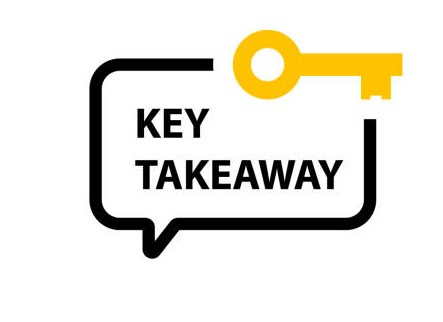

## 1. As expected, the hour of the day matters even on a eight month span. Electricity consumption is maximum at 6pm in the evening. Whereas the mean hourly electricity consumption dips to a minimum at 3 am. So this should inform at what time most generators come on and off the grid. This should inform the hourly forecast of the retail distributors. 

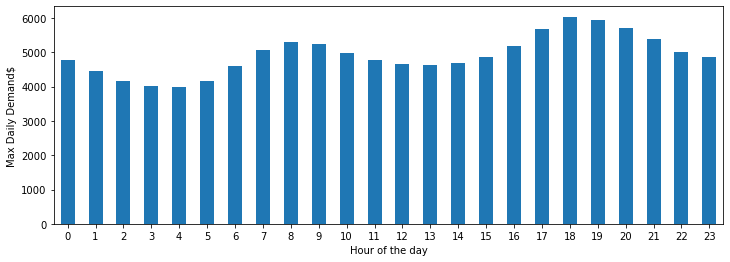

## 2. Lineplot demonstrates weekdays consume more Max energy than weekends for all months except January. This is due to abnormally huge demand on 11.01.2021 and 25.01.2021.  While the spike on 25.01.21 is explainable as it is part of the long weekend ago and maybe associate with Australia day celebrations. On the other hand, the spike on 11.04.22 seems like an abberation. Hence, our stakeholders needs to be prepared for these anamolies. 
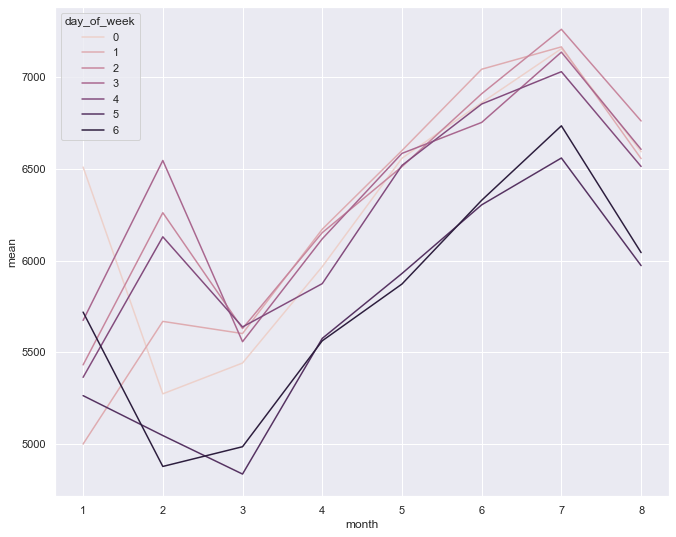



### Another anamoly in data is that weekend max consumption dips in February whereas for weekdays it dips in March. This indicates consumers on a aggregate are behaving differently over teh weekeneds either in January or February. Our stakeholders should definitely inspect this further and this abberations can increase or decrease in 2022!!

## 3. For our stakeholders - July seems to be a critical period at the max consumption for both weekdays and weekends peaks together, hence the max capacity and the base load for July will increase substantially as compared to other months

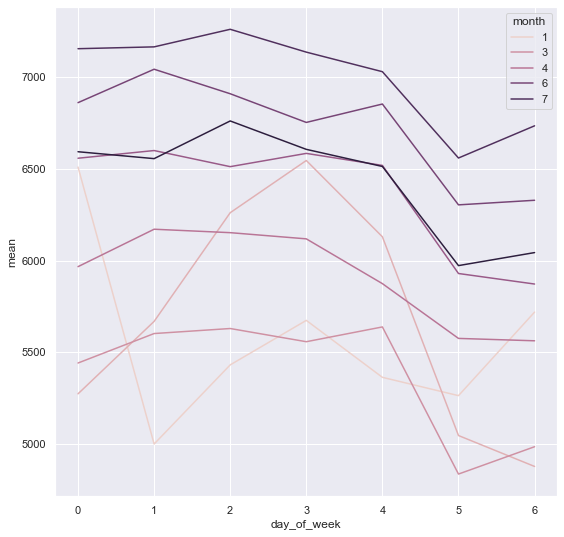



## 4. Three features - month, maximum temperature, and minimum temperature holds a special significance and have high utility for predicting the max daily demand. So for our stakeholder's prespective this should be given high priority and due consideration. 

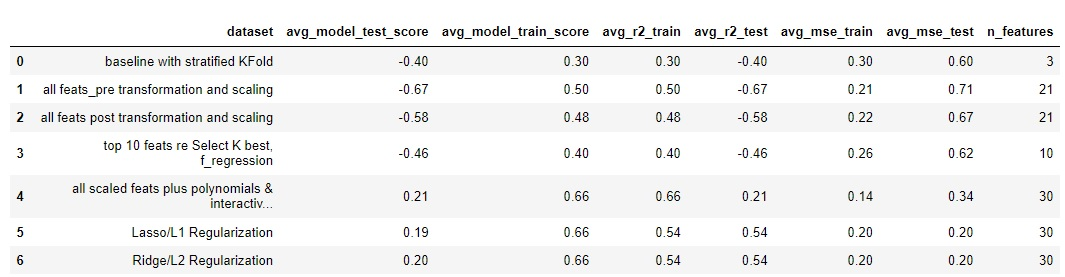